# Gab Model 2.0
2020.10.12

Modify the model.
Use the data extract from gab.ai website to train a model, and test it on two data sets.

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

In [2]:
import pandas as pd
GAB = pd.read_csv('Data/GabHateCorpus_annotations.tsv', encoding='utf-8',sep='\t')

In [3]:
GAB.head()

,ID,Annotator,Text,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM
0,27044,4,Ah the PSYOPS antifa crew is back. That’s how ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27044,15,Ah the PSYOPS antifa crew is back. That’s how ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27044,10,Ah the PSYOPS antifa crew is back. That’s how ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27044,8,Ah the PSYOPS antifa crew is back. That’s how ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27045,4,Get the new Android app update released today ...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
[print(i) for i in GAB.loc[:15]['Text']][0]

Ah the PSYOPS antifa crew is back. That’s how I know we are winning.
Ah the PSYOPS antifa crew is back. That’s how I know we are winning.
Ah the PSYOPS antifa crew is back. That’s how I know we are winning.
Ah the PSYOPS antifa crew is back. That’s how I know we are winning.
Get the new Android app update released today here: https://gab.ai/about/android
Get the new Android app update released today here: https://gab.ai/about/android
Get the new Android app update released today here: https://gab.ai/about/android
Study: Google Pushes Liberal News in Top 5 Search Suggestions https://www.newsbusters.org/blogs/techwatch/corinn...
Study: Google Pushes Liberal News in Top 5 Search Suggestions https://www.newsbusters.org/blogs/techwatch/corinn...
Study: Google Pushes Liberal News in Top 5 Search Suggestions https://www.newsbusters.org/blogs/techwatch/corinn...
Study: Google Pushes Liberal News in Top 5 Search Suggestions https://www.newsbusters.org/blogs/techwatch/corinn...
#Breaking: Claimi

In [5]:
new_label = GAB.groupby('ID')['Hate'].mean() > 0.5

In [6]:
temp = []
for i in new_label:
    if i is True:
        temp.append(1.0)
    else:
        temp.append(0.0)
new_label = temp

In [7]:
new_GAB = GAB.drop_duplicates(subset=['ID'])

In [8]:
new_GAB['Hate'] = temp

<ipython-input-8-a2733beb0c54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_GAB['Hate'] = temp


In [9]:
new_GAB = new_GAB[['Text','Hate']]

In [10]:
new_GAB.head()

,Text,Hate
0,Ah the PSYOPS antifa crew is back. That’s how ...,0.0
4,Get the new Android app update released today ...,0.0
7,Study: Google Pushes Liberal News in Top 5 Sea...,0.0
11,#Breaking: Claiming bias against conservatives...,1.0
15,"“These [companies] are run by sociopaths,” he ...",0.0


In [11]:
new_GAB = new_GAB.reset_index(drop = True)

In [12]:
[print(i) for i in new_GAB.loc[30:35]['Text']][0]

'Through the Arches, Mission San Juan Capistrano' 🖼️   by Joseph Kleitsch  #fineart #architecture #impressionism
'Look Maggie, I'm walkin, Maggie' 😇😍   https://youtu.be/whS9K5rL_FU  #cuteness #babyfever
'Night Slid Down' by Emma Florence Harrison 🎨   #ArtNouveau #illustration #MotherhoodInArt #NightSky
'Old laguna' by Joseph Kleitsch 🇭🇺🇺🇸  #arte #impressionist #landscape #StreetScene #ColorfulArt
🎨 Joseph Kleitsch, selfportrait   (Hungarian - American, 1885-1931)    #selfie #MenInArt #hats #painter
'Under the sun' by Joseph Kleitsch 🇭🇺🇺🇸  #art #impressionism #ColorfulArt #gardens #fineart #WomenInArt


In [13]:
str(new_GAB.loc[31]['Text'])

"'Look Maggie, I'm walkin, Maggie' 😇😍   https://youtu.be/whS9K5rL_FU  #cuteness #babyfever"

In [14]:
# define emoji df and add to new tokens
import re
from tqdm import tqdm, trange
from collections import namedtuple, Counter

file_name = 'Data/emoji-test.txt'
def extract_emoji(file_name):
    with open(file_name, 'rt',encoding='UTF-8') as file:
        emoji_raw = file.read()
    EmojiEntry = namedtuple('EmojiEntry', ['codepoint', 'status', 'emoji', 'name', 'group', 'sub_group'])
    E_regex = re.compile(r' ?E\d+\.\d+ ') # remove the pattern E<digit(s)>.<digit(s)>
    emoji_entries = []

    for line in tqdm(emoji_raw.splitlines()[32:]):  # skip the explanation lines
        if line == '# Status Counts':  # the last line in the document
            break
        if 'subtotal:' in line:  # these are lines showing statistics about each group, not needed
            continue
        if not line:  # if it's a blank line
            continue
        if line.startswith('#'):  # these lines contain group and/or sub-group names
            if '# group:' in line:
                group = line.split(':')[-1].strip()
            if '# subgroup:' in line:
                subgroup = line.split(':')[-1].strip()
        if group == 'Component':  # skin tones, and hair types, skip, as mentioned above
            continue
        if re.search('^[0-9A-F]{3,}', line):  # if the line starts with a hexadecimal number (an emoji code point)
            # here we define all the elements that will go into emoji entries
            codepoint = line.split(';')[0].strip()  # in some cases it is one and in others multiple code points
            status = line.split(';')[-1].split()[0].strip() # status: fully-qualified, minimally-qualified, unqualified
            if line[-1] == '#':
                # The special case where the emoji is actually the hash sign "#". In this case manually assign the emoji
                if 'fully-qualified' in line:
                    emoji = '#️⃣'
                else:
                    emoji = '#⃣'  # they look the same, but are actually different 
            else:  # the default case
                emoji = line.split('#')[-1].split()[0].strip()  # the emoji character itself
            if line[-1] == '#':  # (the special case)
                name = '#'
            else:  # extract the emoji name
                split_hash = line.split('#')[1]
                rm_capital_E = E_regex.split(split_hash)[1]
                name = rm_capital_E
            templine = EmojiEntry(codepoint=codepoint,
                                  status=status,
                                  emoji=emoji,
                                  name=name,
                                  group=group,
                                  sub_group=subgroup)
            emoji_entries.append(templine)

    emoji_dict = {x.emoji: x for x in emoji_entries}

    multi_codepoint_emoji = []
    for code in tqdm([c.codepoint.split() for c in emoji_entries]):
        if len(code) > 1:
            # turn to a hexadecimal number zfilled to 8 zeros e.g: '\U0001F44D'
            hexified_codes = [r'\U' + x.zfill(8) for x in code]  
            hexified_codes = ''.join(hexified_codes)  # join all hexadecimal components 
            multi_codepoint_emoji.append(hexified_codes)

    # sorting by length in decreasing order is extremely important as demonstrated above
    multi_codepoint_emoji_sorted = sorted(multi_codepoint_emoji, key=len, reverse=True)

    # join with a "|" to function as an "or" in the regex
    multi_codepoint_emoji_joined = '|'.join(multi_codepoint_emoji_sorted)  

    single_codepoint_emoji = []

    for code in [c.codepoint.split() for c in emoji_entries]:
        if len(code) == 1:
            single_codepoint_emoji.append(code[0])

    def get_ranges(nums):
        """Reduce a list of integers to tuples of local maximums and minimums.

        :param nums: List of integers.
        :return ranges: List of tuples showing local minimums and maximums
        """
        nums = sorted(nums)
        lows = [nums[0]]
        highs = []
        if nums[1] - nums[0] > 1:
            highs.append(nums[0])
        for i in range(1, len(nums)-1):
            if (nums[i] - nums[i-1]) > 1:
                lows.append(nums[i])
            if (nums[i + 1] - nums[i]) > 1:
                highs.append(nums[i])
        highs.append(nums[-1])
        if len(highs) > len(lows):
            lows.append(highs[-1])
        return [(l, h) for l, h in zip(lows, highs)]

    single_codepoint_emoji_int = [int(x, base=16) for x in single_codepoint_emoji]
    single_codepoint_emoji_ranges = get_ranges(single_codepoint_emoji_int)

    single_codepoint_emoji_raw = r''  # start with an empty raw string
    for code in single_codepoint_emoji_ranges:
        if code[0] == code[1]:  # in this case make it a single hexadecimal character
            temp_regex =  r'\U' + hex(code[0])[2:].zfill(8)
            single_codepoint_emoji_raw += temp_regex
        else:
            # otherwise create a character range, joined by '-'
            temp_regex = '-'.join([r'\U' + hex(code[0])[2:].zfill(8), r'\U' + hex(code[1])[2:].zfill(8)])
            single_codepoint_emoji_raw += temp_regex
    all_emoji_regex = re.compile(multi_codepoint_emoji_joined + '|' +  r'[' + single_codepoint_emoji_raw + r']')        
    count = 0
    found_emoji = set()
    for line in emoji_raw.splitlines()[30:]:
        match = all_emoji_regex.findall(line)
        if match:
            if len(match) > 1:
                break
            count += 1
            found_emoji.add(match[0])
            temp_name = [x.name for x in emoji_entries if x.emoji == match[0]][0]
            assert temp_name in line

    count, found_emoji.__len__()

    with open('Data/emoji_df.csv', 'wt',encoding='utf-8') as file:
        print('emoji;name;group;sub_group;codepoints', file=file)
        for i, em in enumerate(emoji_entries):
            print(f"{em.emoji};{em.name};{em.group};{em.sub_group};{em.codepoint}", file=file)
            

In [15]:
# the emoji list
import pandas as pd
pd.options.display.max_columns = None
extract_emoji(file_name)
emoji_all = []
emoji_df = pd.read_csv('Data/emoji_df.csv', sep=';')
for i in emoji_df['emoji']:
    emoji_all.append(i)
emoji_df.head()

100%|██████████████████████████████████████████████████████████████████████████| 4581/4581 [00:00<00:00, 814122.56it/s]


,emoji,name,group,sub_group,codepoints
0,😀,grinning face,Smileys & Emotion,face-smiling,1F600
1,😃,grinning face with big eyes,Smileys & Emotion,face-smiling,1F603
2,😄,grinning face with smiling eyes,Smileys & Emotion,face-smiling,1F604
3,😁,beaming face with smiling eyes,Smileys & Emotion,face-smiling,1F601
4,😆,grinning squinting face,Smileys & Emotion,face-smiling,1F606


In [16]:
import re
from tqdm import tqdm
import emoji

class Word_Preprocessing():
    def eliminate_url(self,df,target):
        print('Start eliminate url: : )')
        df_temp = df
        target_column_name = target
        text = df_temp[target_column_name]
        for i in tqdm(text):
            urls = re.findall(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', i)
            for i in urls:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def eliminate_username(self,df,target):
        print('Start eliminate username: : )')
        df_temp = df
        target_column_name = target
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'@\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
     
    def eliminate_hashtag(self, df, target):
        df_temp = df
        target_column_name = target
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'#\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def convert_abbreviation(self, df, target):
        df_temp = df
        target_column_name = target
        am = "'m"
        are = "'re"
        have = "'ve"
        not_ = "n't"
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(am, " am"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(are, "  are"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(have, " have"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(not_, " not"))
        return df_temp
        
    
    def eliminate_symbol(self,df,target):
        print('Start eliminate symbol: : )')
        df_temp = df
        target_column_name = target
        symbol_list = [',',"'",'!','@','$','%','^','&','*','(',')','-','+','?','>','<','=','.',':',';','  ','  ','   ','    ','      ','      ','  ']
        for i in tqdm(symbol_list):
            df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ' '))
        return df_temp
    
    def process_all(self, df,target):
        df_temp = df
        target_column_name = target
        df_fresh = self.convert_abbreviation(df_temp,target_column_name)
        df_remove_url = self.eliminate_url(df_fresh,target_column_name)
        df_eliminate_hashtag = self.eliminate_hashtag(df_remove_url, target_column_name)
        df_remove_username = self.eliminate_username(df_eliminate_hashtag, target_column_name)
        df_remove_symbol = self.eliminate_symbol(df_remove_username, target_column_name)
        print("finished!!")
        return df_remove_symbol

In [17]:
word_preprocesser = Word_Preprocessing()

In [18]:
tmp_GAB = word_preprocesser.process_all(new_GAB, 'Text')

  0%|                                                                              | 16/27665 [00:00<02:59, 153.90it/s]

Start eliminate url: : )


  0%|▎                                                                           | 116/27665 [00:00<00:24, 1125.01it/s]

Start eliminate username: : )


 41%|█████████████████████████████████                                                | 11/27 [00:00<00:00, 109.61it/s]

Start eliminate symbol: : )


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 91.89it/s]

finished!!


In [20]:
[print(i) for i in tmp_GAB.loc[30:35]['Text']][0]

 Through the Arches Mission San Juan Capistrano 🖼️ by Joseph Kleitsch 
 Look Maggie I am walkin Maggie 😇😍 
 Night Slid Down by Emma Florence Harrison 🎨 
 Old laguna by Joseph Kleitsch 🇭🇺🇺🇸 
🎨 Joseph Kleitsch selfportrait Hungarian American 1885 1931 
 Under the sun by Joseph Kleitsch 🇭🇺🇺🇸 


In [21]:
all_neg = tmp_GAB[tmp_GAB['Hate'] == 1]

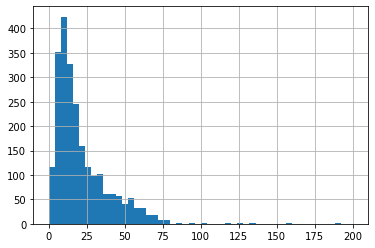

In [22]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in all_neg['Text']]
pd.Series(seq_len).hist(bins = 50,range=[0,200])

In [23]:
tmp_GAB.head()

,Text,Hate
0,Ah the PSYOPS antifa crew is back That’s how I...,0.0
1,Get the new Android app update released today ...,0.0
2,Study Google Pushes Liberal News in Top 5 Sear...,0.0
3,Claiming bias against conservatives has filed...,1.0
4,“These [companies] are run by sociopaths ” he ...,0.0


In [24]:
def count_positive(df):
    count = 0 
    for i in df:
        if i == 1:
            count +=1
    print('total amount of pos:',count)
    print('The ratio of hate data:',count/len(df))

In [25]:
count_positive(tmp_GAB['Hate'])

total amount of pos: 2337
The ratio of hate data: 0.08447496837158865


In [26]:
Train_comment = pd.read_csv('Data/Train_comment.csv',sep=',',encoding = "ISO-8859-1")
dec_comment = pd.read_csv('Data/Val_comment.csv',sep=',',encoding = "ISO-8859-1")
test_comment = pd.read_csv('Data/Test_comment.csv',sep=',',encoding = "ISO-8859-1")

In [27]:
count_positive(Train_comment['attack'])
count_positive(dec_comment['attack'])
count_positive(test_comment['attack'])

total amount of pos: 8079
The ratio of hate data: 0.11620113338894802
total amount of pos: 2755
The ratio of hate data: 0.11895509499136442
total amount of pos: 2756
The ratio of hate data: 0.11890585900422815


In [28]:
pos_train = Train_comment[Train_comment['attack'] == 1]
pos_dev = dec_comment[dec_comment['attack'] == 1]
pos_test = test_comment[test_comment['attack'] == 1]

In [29]:
[print(i) for i in pos_train.iloc[:3]['comment']][0]

 iraq is not good  newline tokennewline token  usa is bad newline tokennewline token
newline tokennewline token newline tokenfuck off you little asshole if you want to talk to me as a human start showing some fear the way humans act around other humans because if you continue your beligerant campaign i will cross another boundary and begin off site recruitmehnt newline tokennewline tokeni can escalate till i am rhetorically nuclear with the whole goddamed mob of you if that is where you think you will find what you want newline tokennewline tokenyou had better start expressing some interest in the concerns presented to you or your credibility as either a document or a community will be about that of a pile of shit 
i have a dick its bigger than yours hahaha


In [30]:
def remove_token(df, target_col):
    df[target_col] = df[target_col].apply(lambda x: x.replace("newline token", " "))
#     df = df.apply(lambda x: x.replace("TAB_TOKEN", " "))
    return df

In [31]:
pos_train = remove_token(pos_train, 'comment')
pos_dev = remove_token(pos_dev, 'comment')
pos_test = remove_token(pos_test, 'comment')

<ipython-input-30-c25d260af15c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_col] = df[target_col].apply(lambda x: x.replace("newline token", " "))


In [32]:
[print(i) for i in pos_train.iloc[:3]['comment']][0]

 iraq is not good      usa is bad   
    fuck off you little asshole if you want to talk to me as a human start showing some fear the way humans act around other humans because if you continue your beligerant campaign i will cross another boundary and begin off site recruitmehnt   i can escalate till i am rhetorically nuclear with the whole goddamed mob of you if that is where you think you will find what you want   you had better start expressing some interest in the concerns presented to you or your credibility as either a document or a community will be about that of a pile of shit 
i have a dick its bigger than yours hahaha


In [33]:
pos_train_tmp = word_preprocesser.process_all(pos_train,'comment')
pos_dev_tmp = word_preprocesser.process_all(pos_dev,'comment')
pos_test_tmp = word_preprocesser.process_all(pos_test,'comment')

<ipython-input-16-c93bda0994eb>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(am, " am"))
<ipython-input-16-c93bda0994eb>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(are, "  are"))
<ipython-input-16-c93bda0994eb>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Start eliminate url: : )
Start eliminate username: : )
Start eliminate symbol: : )


<ipython-input-16-c93bda0994eb>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ' '))
100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 716.79it/s]

finished!!
Start eliminate url: : )
Start eliminate username: : )
Start eliminate symbol: : )
finished!!
Start eliminate url: : )
Start eliminate username: : )
Start eliminate symbol: : )
finished!!


In [34]:
racism_word = pd.read_csv('Data/racism_word.csv')

In [35]:
racist_word_list = racism_word['Content']

In [36]:
racist_word_list = [i.lower() for i in racist_word_list]

In [37]:
import numpy as np
def find_hate_sentence(df):
    hate_sentence = []
    for sentence in tqdm(df):
        for word in racist_word_list:
            if sentence.find(word)>0:
                hate_sentence.append(sentence)
    return list(np.unique(hate_sentence))

In [38]:
pos_train_hate = find_hate_sentence(pos_train_tmp['comment'])
pos_test_hate = find_hate_sentence(pos_test_tmp['comment'])
pos_dev_hate = find_hate_sentence(pos_dev_tmp['comment'])

100%|████████████████████████████████████████████████████████████████████████████| 2755/2755 [00:00<00:00, 7221.34it/s]


In [39]:
hate_extra = pos_train_hate + pos_test_hate + pos_dev_hate  

In [40]:
print("The number of extra hate speech:", len(hate_extra))

The number of extra hate speech: 3942


In [41]:
label_extra  =[]
[label_extra.append(1) for i in range(len(hate_extra))][0]

In [42]:
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, y_train_label, y_test_label = train_test_split(tmp_GAB['Text'], tmp_GAB['Hate'],
                                                stratify=tmp_GAB['Hate'], 
                                                test_size=0.3)

In [43]:
hate_all = list(X_train_text) + hate_extra
label_all = list(y_train_label) + label_extra

In [44]:
hate_test_final = list(X_test_text)
y_test_label = list(y_test_label)

In [45]:
test_hate = {'Hate_speech':hate_test_final,
                'Label':y_test_label}
test_hate_df = pd.DataFrame(test_hate)

In [46]:
final_hate = {'Hate_speech':hate_all,
                'Label':label_all}
final_hate_df = pd.DataFrame(final_hate)

In [47]:
X_train_text, X_valid_text, y_train_label, y_valid_label = train_test_split(final_hate_df['Hate_speech'], final_hate_df['Label'],
                                                stratify=final_hate_df['Label'], 
                                                test_size=0.25)

In [48]:
train_hate = {'Hate_speech':X_train_text,
                'Label':y_train_label}
train_hate_df = pd.DataFrame(train_hate)

In [49]:
valid_hate = {'Hate_speech':X_valid_text,
                'Label':y_valid_label}
valid_hate_df = pd.DataFrame(valid_hate)

In [50]:
train_hate_df['Label'] = train_hate_df['Label'].astype(int)
valid_hate_df['Label'] = valid_hate_df['Label'].astype(int)
test_hate_df['Label'] = test_hate_df['Label'].astype(int)

In [51]:
train_hate_df.to_csv('Data/hate_train.csv',index=False,header=True)
valid_hate_df.to_csv('Data/hate_val.csv',index=False,header=True)
test_hate_df.to_csv('Data/hate_test.csv',index=False,header=True)

In [52]:
source_folder = 'Data'
destination_folder = 'Model'

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import transformers
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [56]:
len(tokenizer)

30522

In [57]:

# # increase
# from tqdm import tqdm
# for i in tqdm(emoji_df['emoji']):
#     tokenizer.add_tokens(i)

In [58]:
len(tokenizer)

30522

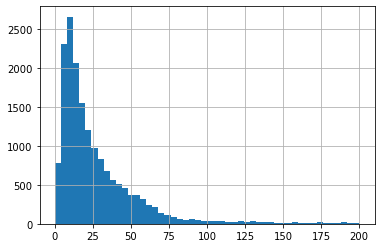

In [59]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_hate_df['Hate_speech']]
pd.Series(seq_len).hist(bins = 50,range=[0,200])

In [60]:
train_hate_df.head()

,Hate_speech,Label
17757,Nuclear Assault Critical Mass MetalMonday,0
14874,THEY WERE NOT INVITED THEY RE NOT WELCOME HERE,0
11603,I do not even want to THINK about what telegon...,0
16925,Star spangled banner as you never heard it,0
12760,Giving women blacks and socialists the right t...,0


In [65]:
# check word tokenize in a text
count = 0
for a,b in train_iter:
    count +=1
    if count == 110:
        print(a)
        break

(tensor([[  101, 10608, 12342,  2015,  1996, 12661,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2019,  5875,  3424,  2273,  2516,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [61]:
# Model parameter
MAX_SEQ_LEN = 75
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Hate_speech', text_field),('Label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='hate_train.csv', validation='hate_val.csv',
                                           test='hate_test.csv', format='CSV', fields=fields, skip_header=True)


train_iter = BucketIterator(train, batch_size=8, sort_key=lambda x: len(x.Hate_speech),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=8, sort_key=lambda x: len(x.Hate_speech),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=8, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (1862 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (880 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1699 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1387 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1138 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1274 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

In [61]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        

        return loss, text_fea

In [62]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [63]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        batch_no = 1
        for (comment, attack), _ in train_loader:
            attack = attack.type(torch.LongTensor)           
            attack = attack.to(device)
            comment = comment.type(torch.LongTensor)  
            comment = comment.to(device)
            output = model(comment, attack)
            loss, _ = output
            print('batch_no [{}/{}]:'.format(batch_no, int(len(train_hate_df)/16)),'training_loss:',loss)
            batch_no+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (comment, attack), _ in valid_loader:
                        attack = attack.type(torch.LongTensor)           
                        attack = attack.to(device)
                        comment = comment.type(torch.LongTensor)  
                        comment = comment.to(device)
                        output = model(comment, attack)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [64]:
from transformers import AdamW
model = BERT().to(device)
no_decay = ['bias', 'LayerNorm.weight']    
optimizer_grouped_parameters = [
{'params': [p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

batch_no [1/1092]: training_loss: tensor(1.1640, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2/1092]: training_loss: tensor(0.7921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3/1092]: training_loss: tensor(0.5808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4/1092]: training_loss: tensor(0.4938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [5/1092]: training_loss: tensor(0.4481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [6/1092]: training_loss: tensor(0.3014, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [7/1092]: training_loss: tensor(0.4416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [8/1092]: training_loss: tensor(0.4280, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [9/1092]: training_loss: tensor(0.2425, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [10/1092]: training_loss: tensor(0.2174, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [11/1092]: training_loss: tensor(0.2218, device='cuda:0', gr

RuntimeError: CUDA error: device-side assert triggered

Model loaded from <== Model/metrics.pt


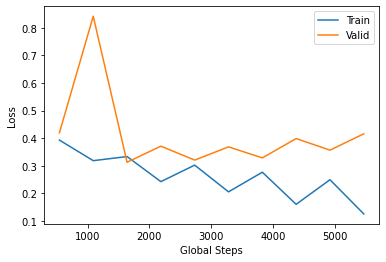

In [74]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [75]:
from sklearn.metrics import roc_curve
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (comment,attack ), _ in test_loader:

                comment = comment.type(torch.LongTensor)           
                comment = comment.to(device)
                attack = attack.type(torch.LongTensor)  
                attack = attack.to(device)
                output = model(comment, attack)

                _, output = output
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(attack.tolist())
    return y_true, y_pred,y_prob    

In [76]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

y_true, y_pred,y_prob = evaluate(best_model, test_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model/model.pt


In [77]:
label_true = []
for i in y_true:
    if i == 1:
        label_true.append([1,0])
    else:
        label_true.append([0,1])

In [78]:
y_prob_final = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempB/(tempA+tempB))

Classification Report:
              precision    recall  f1-score   support

           1     0.0840    0.0300    0.0442       701
           0     0.9155    0.9699    0.9419      7599

    accuracy                         0.8905      8300
   macro avg     0.4998    0.4999    0.4930      8300
weighted avg     0.8453    0.8905    0.8661      8300



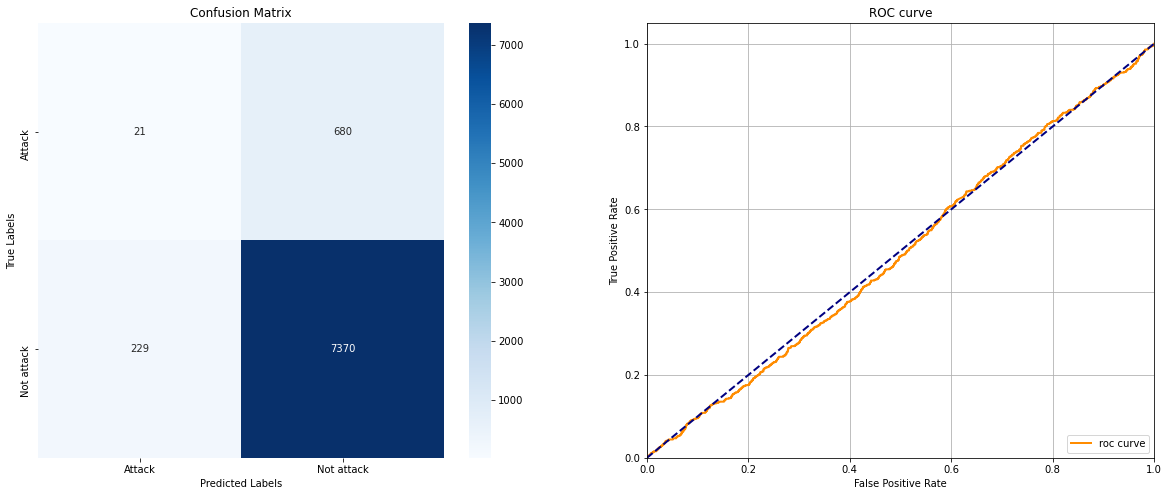

In [79]:
# 2.0 on test data
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [80]:
test_data2400 = pd.read_csv('Data/test5.csv',sep=',',encoding = "ISO-8859-1")

In [81]:
test_data2400.head()

,comment,attack
0,fucking piece of shit your whole community is...,1.0
1,im not being funny but coronavirus in china ir...,0.0
2,got on the victoria line today to seven sister...,1.0
3,it s appalling that the media amp libtards bit...,1.0
4,dude fuck the chinese man fuck em and if you t...,1.0


In [82]:
test_data2400['attack'] = [int(i) for i in test_data2400['attack']]

In [ ]:
count_positive(test_data2400['attack'])

In [83]:
# Model parameter
MAX_SEQ_LEN = 75
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('hate', label_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=source_folder, train='hate_train.csv', validation='hate_val.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)


test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2295 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (854 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2207 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1928 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (941 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [84]:
y_true, y_pred,y_prob = evaluate(best_model, test_iter)

In [85]:
label_true = []
for i in y_true:
    if i == 1:
        label_true.append([1,0])
    else:
        label_true.append([0,1])

In [86]:
y_prob_final = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempB/(tempA+tempB))

Classification Report:
              precision    recall  f1-score   support

           1     0.3658    0.1829    0.2439       678
           0     0.7202    0.8690    0.7876      1641

    accuracy                         0.6684      2319
   macro avg     0.5430    0.5259    0.5157      2319
weighted avg     0.6166    0.6684    0.6286      2319



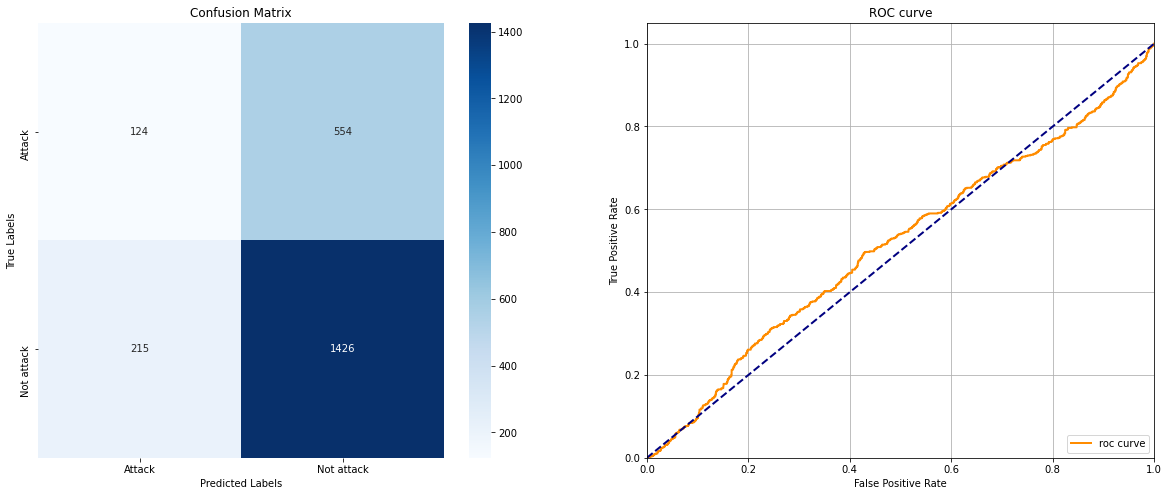

In [87]:
#2.0 on 2400 data
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       231
           0     0.9165    1.0000    0.9564      2535

    accuracy                         0.9165      2766
   macro avg     0.4582    0.5000    0.4782      2766
weighted avg     0.8399    0.9165    0.8765      2766



F:\conda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


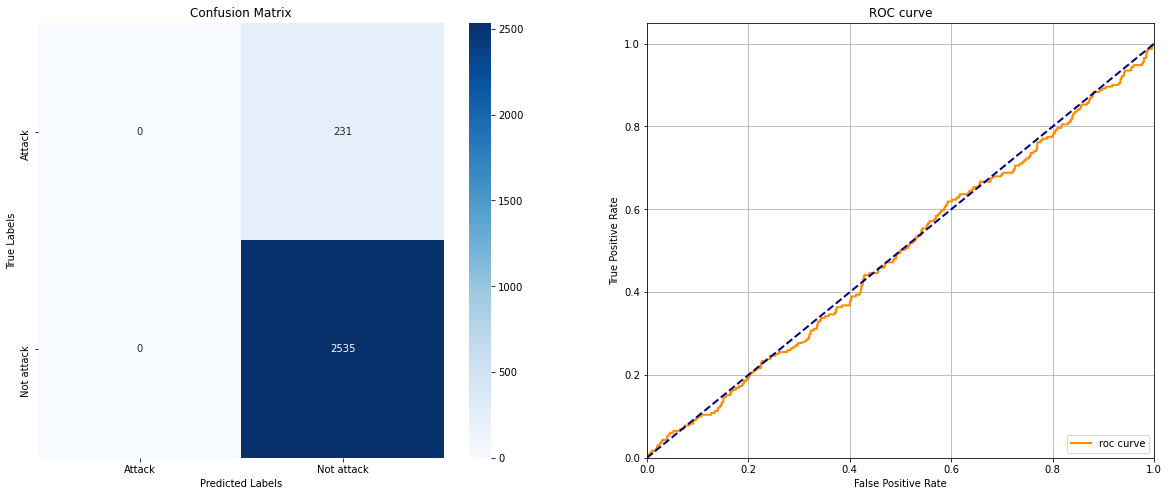

In [38]:
# 1.0 on test dataset
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       678
           0     0.7076    1.0000    0.8288      1641

    accuracy                         0.7076      2319
   macro avg     0.3538    0.5000    0.4144      2319
weighted avg     0.5007    0.7076    0.5865      2319



F:\conda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


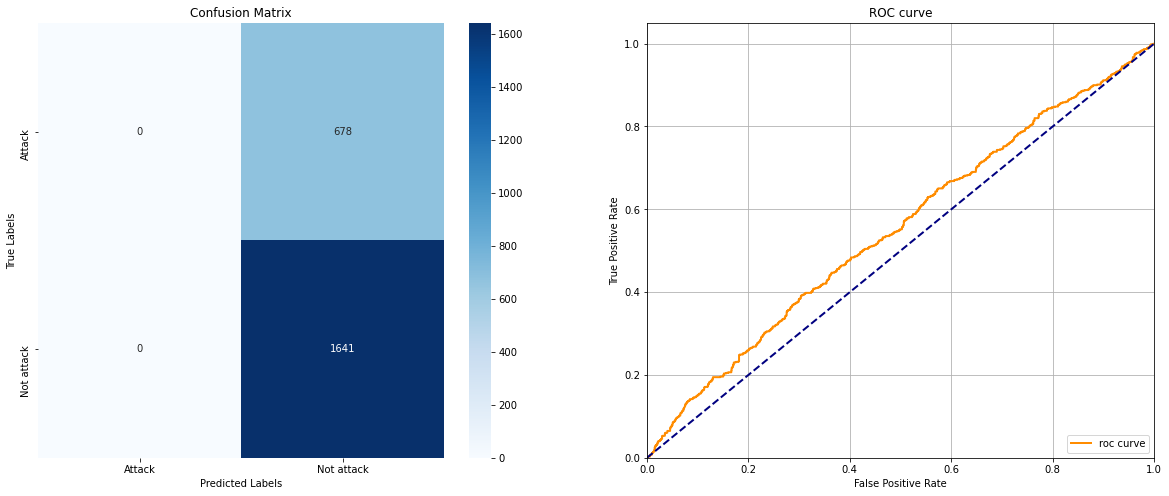

In [46]:
# 1.0 on 2400 data set
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()